In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 26 21:00:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import shutil

In [5]:
#shutil.copyfile("/content/gdrive/MyDrive/stat430project/semantic2d/data_2d_semantics.7z", "/content/data_2d_semantics.7z")
!7z x "/content/gdrive/MyDrive/stat430project/semantic2d/data_2d_semantics.7z" -o"/content/"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/MyDrive/stat430project/semantic2d/                                                            1 file, 53486976622 bytes (50 GiB)

Extracting archive: /content/gdrive/MyDrive/stat430project/semantic2d/data_2d_semantics.7z
--
Path = /content/gdrive/MyDrive/stat430project/semantic2d/data_2d_semantics.7z
Type = 7z
Physical Size = 53486976622
Headers Size = 1018194
Method = LZMA2:26
Solid = +
Blocks = 4

  0%    
Would you like to replace the existing file:
  Path:     /content/data_2d_semantics/2013_05_28_drive_train_frames.txt
  Size:     7693628 bytes (7514 KiB)
  Modified: 2021-10-31 08:00:13
with the file fr

In [ ]:
# find -name '*.png' | sort -n | # find pngs
# gawk 'BEGIN{ a=1 }{ printf "mv %s %04d.png\n", $0, a++ }' | # build mv command
# bash

In [ ]:
#!cd /content/ && bash /content/gdrive/MyDrive/stat430project/semantic2d/download_2d_perspective.sh

In [ ]:
# !wget "https://s3.eu-central-1.amazonaws.com/avg-projects/KITTI-360/ed180d24c0a144f2f1ac71c2c655a3e986517ed8/data_2d_semantics.zip"
# Pre-process this data so that only the images we  need are there

In [ ]:
# Move zip from drive to local environment
# so that data extraction is easier
#import shutil
#shutil.copyfile("data_2d_semantics.zip", "/content/data_2d_semantics.zip")
#!unzip -q "/content/data_2d_semantics.zip" -d "/content/"

In [12]:
#!pip install git+https://github.com/autonomousvision/kitti360Scripts.git

In [10]:
#!wget -P "/content/gdrive/MyDrive/stat430project" "https://raw.githubusercontent.com/autonomousvision/kitti360Scripts/master/kitti360scripts/helpers/labels.py"

In [11]:
#!wget -P "/content/gdrive/MyDrive/stat430project" "https://github.com/autonomousvision/kitti360Scripts/blob/master/kitti360scripts/helpers/annotation.py"

In [8]:
#!pip install torch  PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [32]:
import torch
from torchvision import datasets, transforms
import helper
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import cv2
import torch.nn as nn

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30
!pip install -U opencv-python

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.64.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-65fa80df.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-09fe7800.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [27]:
!pip list | grep opencv

opencv-contrib-python         4.5.5.64
opencv-python                 4.5.5.64
opencv-python-headless        4.1.2.30


In [26]:
ignore_index = 255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, 36, 38,
                39, 40, 41, 42, 43, 44, -1]

valid_classes = [ignore_index, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23,
                 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 37]

class_names = ["unlabelled", "road", "sidewalk", "building", "wall", "fence",
               "pole", "traffic light", "traffic sign", "vegetation",
               "terrain", "sky", "person", "rider", "car", "truck",
               "bus", "train", "motorcycle", "bicycle", "garage", "gate",
               "smallpole"]

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes = len(valid_classes)
class_map

{7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19,
 34: 20,
 35: 21,
 37: 22,
 255: 0}

In [28]:
colors = [  [  0,  0,  0],
            [128, 64,128],
            [244, 35,232],
            [250,170,160],
            [ 70, 70, 70],
            [102,102,156],
            [190,153,153],
            [153,153,153],
            [250,170, 30],
            [220,220,  0],
            [107,142, 35],
            [152,251,152],
            [ 70,130,180],
            [220, 20, 60],
            [255,  0,  0],
            [  0,  0,142],
            [  0,  0, 70],
            [  0, 60,100],
            [  0, 80,100],
            [  0,  0,230],
            [119, 11, 32],
            [ 64,128,128],
            [190,153,153],
            [153,153,153]]

In [33]:
label_colors = dict(zip(range(n_classes), colors))
label_colors

{0: [0, 0, 0],
 1: [128, 64, 128],
 2: [244, 35, 232],
 3: [250, 170, 160],
 4: [70, 70, 70],
 5: [102, 102, 156],
 6: [190, 153, 153],
 7: [153, 153, 153],
 8: [250, 170, 30],
 9: [220, 220, 0],
 10: [107, 142, 35],
 11: [152, 251, 152],
 12: [70, 130, 180],
 13: [220, 20, 60],
 14: [255, 0, 0],
 15: [0, 0, 142],
 16: [0, 0, 70],
 17: [0, 60, 100],
 18: [0, 80, 100],
 19: [0, 0, 230],
 20: [119, 11, 32],
 21: [64, 128, 128],
 22: [190, 153, 153]}

In [34]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for void_class in void_classes:
        mask[mask == void_class] = ignore_index
    for valid_class in valid_classes:
        mask[mask == valid_class] = class_map[valid_class]
    return mask

In [35]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colors[l][0]
        g[temp == l] = label_colors[l][1]
        b[temp == l] = label_colors[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [1]:
#! pip install -U albumentations

In [ ]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# transform=A.Compose(
# [
#     A.Resize(256, 512),
#     A.HorizontalFlip(),
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#     A.pytorch.ToTensorV2(),
# ]
# )

In [ ]:
# transforms = transforms.Compose([
#   transforms.ToTensor(),
#   #transforms.Resize(int(1.15 * imsize)),
#   #transforms.RandomCrop(imsize),
#   #transforms.RandomHorizontalFlip(.5),
#   #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [36]:
from PIL import Image
import numpy as np
import albumentations as A

In [37]:
def image_show(data_loader,n):

  #Read Augmented image data
  data_iter = iter(data_loader)
  for i in range(1):
    images,labels = data_iter.next()

  #Convert image from tensor to numpy
  images = images.cpu().detach().numpy()

  #Take out n images one by one and display them
  for i in range(n):
    image = np.transpose(images[i],[1,2,0])
    plt.imshow(image, aspect='auto')
    plt.show()

In [38]:
def mask_show(data_loader, n):

  #Read Augmented image data
  data_iter = iter(data_loader)
  for i in range(1):
    images,labels = data_iter.next()

  #Convert image from tensor to numpy
  labels = labels.cpu().detach().numpy()

  #Take out n images one by one and display them
  for i in range(n):
    #label = np.transpose(labels[i], [1,2,0])
    label = labels[i]
    print(label.shape)
    plt.imshow(label, aspect='auto')
    plt.show()

In [39]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [40]:
transform = transforms.Compose([
                        transforms.Resize(224),
                        #transforms.RandomCrop(imsize),
                        #transforms.RandomHorizontalFlip(.5),
                        #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                        ])

In [41]:
class KittiDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    # default size of images is 3 x 1408 x 376
    #try to get albumentations working for better transform applies
    
    if self.transform is not None:
      Norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      tens = transforms.ToTensor()
      #augmentations = transforms(image=image, mask=mask)
      #image = augmentations["image"]
      #mask = augmentations["mask"]
      image = tens(image)
      mask = tens(mask)

      image = Norm(image)
      image = transform(image)
      mask = transform(mask).squeeze(0)
    
    return image, mask

In [43]:
data_2d_train_root = "/content/data_2d_semantics/KITTI-360/data_2d_raw_train"
mask_2d_train_root = "/content/data_2d_semantics/KITTI-360/semantic_mask_train"

data_2d_val_root = "/content/data_2d_semantics/KITTI-360/data_2d_raw_val"
mask_2d_val_root = "/content/data_2d_semantics/KITTI-360/semantic_mask_val"

In [44]:
train_dataset = KittiDataset(image_dir=data_2d_train_root, mask_dir=mask_2d_train_root, transform=transforms)

val_dataset = KittiDataset(data_2d_val_root, mask_2d_val_root, transform=transforms)

In [45]:
train_data = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=1, drop_last=True)
val_data = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


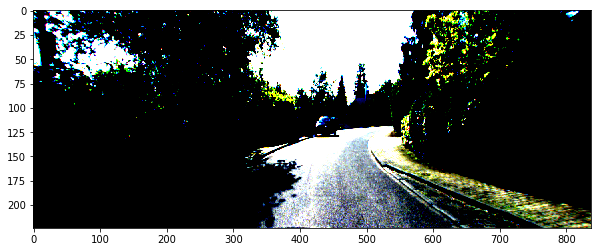

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


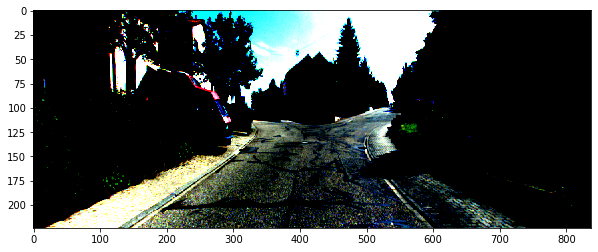

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


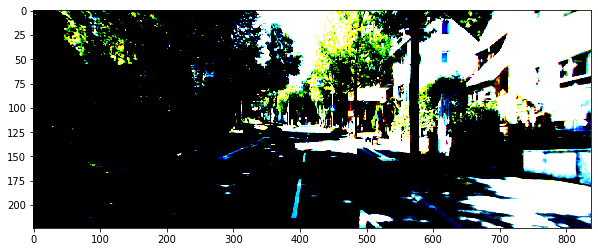

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


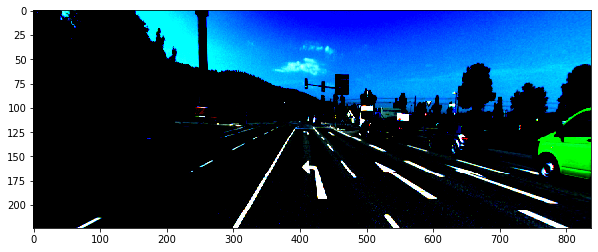

In [46]:
image_show(train_data, 4)

(224, 838)


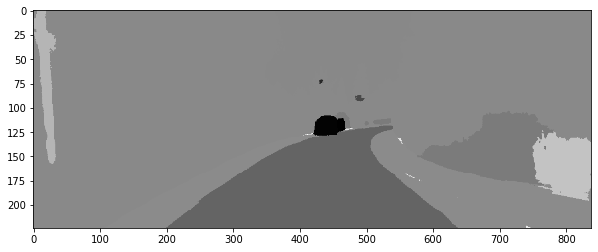

(224, 838)


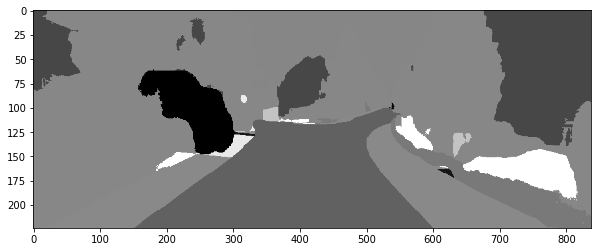

(224, 838)


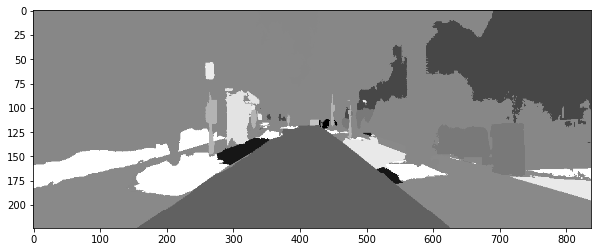

(224, 838)


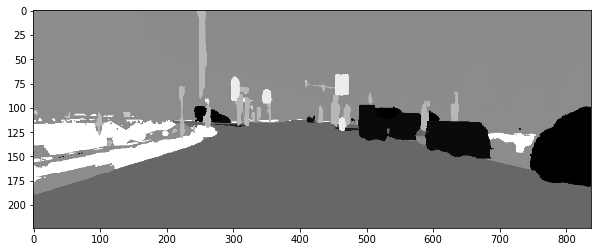

In [47]:
mask_show(train_data, 4)

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [116]:
torch.cuda.is_available()

True

rm: cannot remove '/root/.cache/torch/hub/pytorch_vision_v0.10.0/': No such file or directory


In [125]:
num_epochs = 2

# Load Pretrained DeepLabsV3
classifier = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [129]:
for param in classifier.parameters():
  param.requires_grad = False

In [130]:
#classifier.eval()

In [131]:
# (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#    (3): ReLU()
#    (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
classifier.classifier[4] =  nn.Conv2d(256, n_classes, kernel_size=(1, 1), stride=(1, 1))
classifier.classifier[1].requires_grad = True #should work
classifier.classifier[2].requires_grad = True 
classifier.classifier[3].requires_grad = True 
classifier.classifier[4].requires_grad = True 

In [ ]:
classifier.classifier

In [133]:
classifier.aux_classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(1,1), stride=(1,1))
classifier.aux_classifier[4].requires_grad = True

In [134]:
classifier.aux_classifier

FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(256, 23, kernel_size=(1, 1), stride=(1, 1))
)

In [135]:
device

device(type='cuda', index=0)

In [136]:
classifier = classifier.to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [137]:
def plot_losses(train, val, num_epochs):
    indices = np.arange(num_epochs)
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [138]:
import torchmetrics
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(num_classes=n_classes, compute_on_cpu = False)
jaccard.to(device)

JaccardIndex()

In [139]:
import datetime

In [141]:
# print(datetime.datetime.now())
# losses = []
# val_loss = []
# t_iou = []
# v_iou = []
# for epoch in range(num_epochs):
#   temp_loss = []
#   temp_val_loss = []
#   train_iou = []
#   val_iou = []
#   for batch_idx, (data_, masks_) in enumerate(train_data):
#       data_ = data_.to(device=device, dtype=torch.float32)
#       targets = masks_.to(device=device, dtype=torch.long)
#       #data = None
#       #targets=None
#       #forward
#       scores = classifier(data_)['out'].cuda()
#       targets = encode_segmap(targets)
#       targets = targets.to(device)
#       loss = criterion(scores, targets.long())
#       temp_loss.append(loss.item())

#       #print(scores.get_device())
#       #print(targets.get_device())

#       iou_loss = jaccard(scores, targets)
#       #print(iou_loss.item())
#       train_iou.append(iou_loss.item())


#       #backward
#       optimizer.zero_grad()
#       loss.backward()

#       optimizer.step()

#   train_loss_epoch = sum(temp_loss) / len(temp_loss)
#   train_iou_epoch = train_iou #sum(train_iou)/len(train_iou)
#   train_iou.append(train_iou_epoch)
#   losses.append(train_loss_epoch)
#   t_iou.append(train_iou_epoch)

#   print(f'Cost at epoch {epoch} is {train_loss_epoch}')
#   print(f'IOU at epoch {epoch} is {train_iou_epoch}')
#   print(datetime.datetime.now())

#   with torch.no_grad():
#     for j, (input, target) in enumerate(val_data):
#       input = input.to(device=device, dtype=torch.float32)
#       target = target.to(device=device, dtype=torch.long)
#       target = encode_segmap(target)
#       pred = classifier(input)['out']

#       v_loss = criterion(pred, target.long())
#       temp_val_loss.append(v_loss.item())

#       val_iou_loss = jaccard(pred, target)
#       val_iou.append(val_iou_loss.item())
#   #val_iou = sum(temp_val_loss) / len(temp_val_loss)

#   val_loss_epoch = sum(temp_val_loss) / len(temp_val_loss)

#   val_loss.append(val_loss_epoch)
#   v_iou.append(val_iou)
#   print(f'Val cost at epoch {epoch} is {val_loss_epoch}')
#   print(f'Val IOU at epoch {epoch} is {val_iou}')
#   print("Val:")
#   print(datetime.datetime.now())


In [ ]:
#todo update vars
losses = []
val_loss = []
train_iou_epochs = []
val_iou_epochs = []

train_iou = torchmetrics.JaccardIndex(num_classes=n_classes, compute_on_cpu=False).to(device)
val_iou = torchmetrics.JaccardIndex(num_classes=n_classes, compute_on_cpu=False).to(device)

for epoch in range(num_epochs):
  temp_loss = [] #list to compute mean loss per epoch 
  temp_val_loss = [] #list to compute mean val loss per epoch
# make functions
  for batchidx, (data_, masks_) in enumerate(train_data):
      #put on gpu
      data_ = data_.to(device=device, dtype=torch.float32)
      targets = masks_.to(device=device, dtype=torch.long)
      #forward
      scores = classifier(data_)['out']
      targets = encode_segmap(targets)

      #get loss
      loss = criterion(scores, targets.long())
      #get iou
      train_iou.update(scores,targets)
      #append loss
      temp_loss.append(loss.item())

      #backward
      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
  #compute mean loss
  train_loss_epoch = sum(temp_loss) / len(temp_loss)
  #compute mIOU
  train_iou_current = train_iou.compute()

  losses.append(train_loss_epoch)
  train_iou_epochs.append(train_iou_current)

  with torch.no_grad():
    for j, (input, target) in enumerate(val_data):
      input = input.to(device=device, dtype=torch.float32)
      target = target.to(device=device, dtype=torch.long)

      target = encode_segmap(target)
      pred = classifier(input)['out']

      v_loss = criterion(pred, target.long())
      val_iou.update(pred, target)

      temp_val_loss.append(v_loss.item())

  val_loss_epoch = sum(temp_val_loss) / len(temp_val_loss)
  val_iou_epoch = val_iou.compute()
  val_loss.append(val_loss_epoch)
  val_iou_epochs.append(val_iou_epoch)


  print(f'Cost at epoch {epoch+1} is {train_loss_epoch}')
  print(f'IoU at epoch {epoch+1} is {train_iou_current}')
  print(f'Val Cost at epoch {epoch+1} is {val_loss_epoch}')
  print(f'IoU at epoch {epoch+1} is {val_iou_epoch}')

  #reset the metrics
  train_iou.reset()
  val_iou.reset()


In [ ]:
torch.save(classifier.state_dict(), "/content/gdrive/MyDrive/stat430project")

In [ ]:
plot_losses(losses, val_loss, num_epochs)

In [ ]:
torch.save(classifier.state_dict(), "/content/gdrive/MyDrive/stat430project")

In [ ]:
sample=6
invimg=inv_normalize(img[sample])
outputx=output.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
#ax[1].imshow(encoded_mask,cmap='gray') #(256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')

In [ ]:
# simple IoU with np
# intersection = np.logical_and(target, prediction)
# union = np.logical_or(target, prediction)
# iou_score = np.sum(intersection) / np.sum(union)
# average over classes

In [ ]:
#https://towardsdatascience.com/how-to-design-reinforcement-learning-reward-function-for-a-lunar-lander-562a24c393f6